In [20]:
import sys
import numpy as np
import pandas as pd

import seaborn as sns

import xgboost as xgb

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

### Read train and test datatset

In [2]:
train = pd.read_csv("/Users/Home/Documents/Python Scripts/Black Friday/train_bf.csv") 
test = pd.read_csv("/Users/Home/Documents/Python Scripts/Black Friday/test_bf.csv") 


### Create copies of datasets to tweak the data for model deployment

In [3]:
train_bf = train.copy()
test_bf = test.copy()

### Create label from original dataset for model parameter to train with the copied datatset

In [4]:
train_pur_reg = np.array(train["Purchase"])
test_pur_reg = np.array(test["Purchase"])

In [5]:
train_bf.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [6]:
test_bf.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,2.335990e+05,233599.000000,233599.000000,233599.000000,161255.000000,71037.000000,233599.00000
mean,1.003029e+06,8.085407,0.410070,5.276542,9.849586,12.669454,9318.28001
std,1.726505e+03,6.521146,0.491847,3.736380,5.094943,4.125944,4972.71383
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,185.00000
25%,1.001527e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5861.00000
50%,1.003070e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8059.00000
75%,1.004477e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12060.00000
max,1.006040e+06,20.000000,1.000000,18.000000,18.000000,18.000000,23961.00000


In [7]:
train_bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [8]:
test_bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN,8370
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN,15200
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN,1422
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN,1057
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0,7969


### Fill in the missing values in both datasets

In [9]:
train_bf = train_bf.fillna(train_bf['Product_Category_2'].value_counts().index[0])
train_bf = train_bf.fillna(train_bf['Product_Category_3'].value_counts().index[0])


test_bf = test_bf.fillna(test_bf['Product_Category_2'].value_counts().index[0])
test_bf = test_bf.fillna(test_bf['Product_Category_3'].value_counts().index[0])

In [35]:
analysis=train_bf.copy()

### Data Visulaization depending on dataset columns

In [36]:
sns.countplot(analysis['Age'])
plt.figure(1, figsize=(15,5))
sns.countplot(analysis['Product_Category_1'], hue=analysis['Age'])

In [37]:
sns.countplot(analysis['Occupation'])
plt.figure(1, figsize=(15,5))
sns.countplot(analysis['Product_Category_1'], hue=analysis['Occupation'])

In [38]:
sns.countplot(analysis['City_Category'])
plt.figure(1, figsize=(15,5))
sns.countplot(analysis['Product_Category_1'], hue=analysis['City_Category'])

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr())

### Drop purchase from copy dataset as it is being used as a label from the original dataset

In [11]:
train_bf.drop('Purchase',axis=1)
test_bf.drop('Purchase',axis=1)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,8.0
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,8.0
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,8.0
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,8.0
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0
5,1000013,P00350442,M,46-50,1,C,3,1,2,3.0,15.0
6,1000013,P00155442,M,46-50,1,C,3,1,1,11.0,15.0
7,1000013,P0094542,M,46-50,1,C,3,1,2,4.0,9.0
8,1000015,P00161842,M,26-35,7,A,1,0,10,13.0,16.0
9,1000022,P00067942,M,18-25,15,A,4+,0,5,14.0,8.0


### Converting categorical values to numerical

In [12]:
train_cat_to_num = {"Stay_In_Current_City_Years": {"4+": 4,},
              "Age": {"0-17": 15, "18-25": 21, "26-35": 30, "36-45": 40,"46-50": 48, "51-55": 12, "55+":60 }}

test_cat_to_num = {"Stay_In_Current_City_Years": {"4+": 4,},
              "Age": {"0-17": 15, "18-25": 21, "26-35": 30, "36-45": 40,"46-50": 48, "51-55": 12, "55+":60 }}

In [13]:
from sklearn.preprocessing import LabelEncoder

train_make = LabelEncoder()
train_bf["City_Category_Num"] = train_make.fit_transform(train_bf["City_Category"])
train_bf[["City_Category_Num", "City_Category"]].head(11)

test_make = LabelEncoder()
test_bf["City_Category_Num"] = test_make.fit_transform(test_bf["City_Category"])
test_bf[["City_Category_Num", "City_Category"]].head(11)

,City_Category_Num,City_Category
0,1,B
1,2,C
2,1,B
3,1,B
4,2,C
5,2,C
6,2,C
7,2,C
8,0,A
9,0,A


In [14]:
train_bf.replace(train_cat_to_num, inplace=True)
train_bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_Num
0,1000001,P00069042,F,15,10,A,2,0,3,8.0,8.0,8370,0
1,1000001,P00248942,F,15,10,A,2,0,1,6.0,14.0,15200,0
2,1000001,P00087842,F,15,10,A,2,0,12,8.0,8.0,1422,0
3,1000001,P00085442,F,15,10,A,2,0,12,14.0,8.0,1057,0
4,1000002,P00285442,M,60,16,C,4,0,8,8.0,8.0,7969,2


In [15]:
test_bf.replace(test_cat_to_num, inplace=True)
test_bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_Num
0,1000004,P00128942,M,48,7,B,2,1,1,11.0,8.0,8370,1
1,1000009,P00113442,M,30,17,C,0,0,3,5.0,8.0,15200,2
2,1000010,P00288442,F,40,1,B,4,1,5,14.0,8.0,1422,1
3,1000010,P00145342,F,40,1,B,4,1,4,9.0,8.0,1057,1
4,1000011,P00053842,F,30,1,C,1,0,4,5.0,12.0,7969,2


### Converting gender categorical to binary

In [16]:
train_bf["Gender"] = np.where(train_bf["Gender"].str.contains("F"), 1,0)

test_bf["Gender"] = np.where(test_bf["Gender"].str.contains("F"), 1,0)

In [17]:
train_bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_Num
0,1000001,P00069042,1,15,10,A,2,0,3,8.0,8.0,8370,0
1,1000001,P00248942,1,15,10,A,2,0,1,6.0,14.0,15200,0
2,1000001,P00087842,1,15,10,A,2,0,12,8.0,8.0,1422,0
3,1000001,P00085442,1,15,10,A,2,0,12,14.0,8.0,1057,0
4,1000002,P00285442,0,60,16,C,4,0,8,8.0,8.0,7969,2


In [18]:
test_bf.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,City_Category_Num
0,1000004,P00128942,0,48,7,B,2,1,1,11.0,8.0,8370,1
1,1000009,P00113442,0,30,17,C,0,0,3,5.0,8.0,15200,2
2,1000010,P00288442,1,40,1,B,4,1,5,14.0,8.0,1422,1
3,1000010,P00145342,1,40,1,B,4,1,4,9.0,8.0,1057,1
4,1000011,P00053842,1,30,1,C,1,0,4,5.0,12.0,7969,2


### Convert all columns to string datatype

In [19]:
train_bf = train_bf.applymap(str)
train_bf.dtypes
print (train_bf.dtypes)

User_ID                       object
Product_ID                    object
Gender                        object
Age                           object
Occupation                    object
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                object
Product_Category_1            object
Product_Category_2            object
Product_Category_3            object
Purchase                      object
City_Category_Num             object
dtype: object


In [20]:
test_bf = test_bf.applymap(str)
test_bf.dtypes
print (test_bf.dtypes)



User_ID                       object
Product_ID                    object
Gender                        object
Age                           object
Occupation                    object
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                object
Product_Category_1            object
Product_Category_2            object
Product_Category_3            object
Purchase                      object
City_Category_Num             object
dtype: object


### Encode categorical variables with label encoding

In [21]:
train_bf = np.array(train_bf)

for i in range(train_bf.shape[1]):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_bf[:,i]))
    train_bf[:, i] = lbl.transform(train_bf[:, i])
train_bf = train_bf.astype(int)

In [22]:
test_bf = np.array(test_bf)

for i in range(test_bf.shape[1]):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(test_bf[:,i]))
    test_bf[:, i] = lbl.transform(test_bf[:, i])
test_bf = test_bf.astype(int)

# XGB Boost Model

In [23]:
params = {}
params["min_child_weight"] = 20
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 10
params["nthread"] = 6
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 67

plst = list(params.items())
num_rounds = 2540

In [24]:
xgtrain = xgb.DMatrix(train_bf,label=train_pur_reg)
model = xgb.train(plst, xgtrain, num_rounds)

xgtest = xgb.DMatrix(test_bf,label=test_pur_reg)

In [25]:
pred=model.predict(xgtest)

In [26]:
test['Purchase'] = pred
test.to_csv('final_xgb.csv', columns=['User_ID', 'Product_ID', 'Purchase'], index=False)

In [27]:
early_stopping=10
cv=xgb.cv(params,xgtrain,50,nfold=5,early_stopping_rounds=early_stopping, verbose_eval=1)
print(cv.mean(),cv.std())

[0]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[1]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[2]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[3]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[4]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[5]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[6]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[7]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[8]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
[9]	train-rmse:8996.77+3.17625	test-rmse:8996.77+12.6942
test-rmse-mean     8996.766406
test-rmse-std        12.694213
train-rmse-mean    8996.774805
train-rmse-std        3.176247
dtype: float64 test-rmse-mean    NaN
test-rmse-std     NaN
train-rmse-mean   NaN
train-rmse-std    NaN
dtype: float64


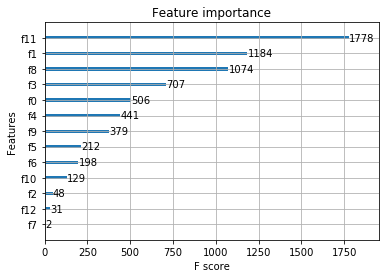

{'f0': 0.4315748946415114,
 'f1': 0.0008711033758858192,
 'f10': 0.0007180868819409303,
 'f11': 0.0018246623661789048,
 'f12': 0.011905800503887102,
 'f2': 0.1692775532292907,
 'f3': 0.0069972830169453505,
 'f4': 0.12144134432413684,
 'f5': 0.01505592027712737,
 'f6': 0.006334850693465357,
 'f7': 12.413882635,
 'f8': 0.0024433514217554893,
 'f9': 0.0007248264904027699}

In [29]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
xgtrain=xgb.DMatrix(train_bf[:train.shape[0],:],label=train_bf[:train.shape[0]])
watchlist=[(xgtrain,'train')]
model_1_xgboost=xgb.train(plst,xgtrain,num_rounds)
plot_importance(model_1_xgboost)
plt.show()
'''print(model_1_xgboost.feature_importances_)
plt.bar(range(len(model_1_xgboost.feature_importances_)),model_1_xgboost.feature_importances_)
plt.show()'''
model_1_xgboost.get_score(importance_type='gain')

### XGB Boost CV score

# Transformer Model 

In [ ]:
transformer = TfidfTransformer()
tfidf_train = transformer.fit_transform(train_bf.astype(int))

tfidf_test = transformer.fit_transform(test_bf.astype(int))

In [ ]:
input_tfidf_train = tfidf_train.toarray()
input_tfidf_test = tfidf_test.toarray()

In [ ]:
params = {}
params["min_child_weight"] = 10
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 12
params["nthread"] = 6
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 0

plst = list(params.items())
num_rounds = 1800

In [ ]:
xgtrain = xgb.DMatrix(input_tfidf_train,label=train_pur_reg)
model = xgb.train(plst, xgtrain, num_rounds)

xgtest = xgb.DMatrix(input_tfidf_test,label=test_pur_reg)

In [ ]:
pred=model.predict(xgtest)

In [ ]:
test['Purchase'] = pred
test.to_csv('final_trans.csv', columns=['User_ID', 'Product_ID', 'Purchase'], index=False)

In [ ]:
xgb.cv(params, xgtrain, num_rounds, nfold=5, seed=5500)